In [1]:
#installation
# !conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
# !pip install transformers
# !pip install pytorch_transformers

In [2]:
# Tutorial copied from https://github.com/huggingface/transformers#usage

In [3]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
CUDA_ENABLED  = 0
from torch.utils.data import Dataset
from itertools import islice
from torch.utils.data import DataLoader
import numpy as np

def to_cuda(tensor):
    if CUDA_ENABLED:
        tensor = tensor.cuda()
    return tensor
def build_sentence_list(start_token, sentences):
    text = [start_token]
    for sentence in sentences:
        text += sentence + ['SEP']
    return text

In [4]:

class CustomDataset(Dataset):
    def __init__(self, filename, num_bunches = 100):
        self.num_bunches = num_bunches
        self.num_lines = 114180969
        self.bunch_width = self.num_lines // num_bunches
        self.filename = filename
        self.set_bunch(0)
    def set_bunch(self, bunch_idx):
        start = bunch_idx * self.bunch_width
        end = (bunch_idx + 1) * self.bunch_width
        with open(self.filename, encoding='iso-8859-1') as f:
            lines = [line[:-1] for line in islice(f, start, end)]
        self.X = lines
    def preprocess(self, text):
        return text
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index]

In [5]:
dataset = CustomDataset('enwiki-latest-pages-articles_preprocessed.txt')

#Wrap it around a dataloader
dataloader = DataLoader(dataset, batch_size = 2, num_workers = 0)

class MaskLMDataset:
    def __init__(self, dataset, dataloader):
        self.dataset = dataset
        self.dataloader = dataloader

In [7]:
itr = 0
for text, lengths_and_masks in dataloader:
    print(len(text))
    itr += 1
    if itr > 2:
        break

10
99
174


In [39]:
import pdb

In [82]:

class PretrainedModel(nn.Module):
    def __init__(self):
        super(PretrainedModel, self).__init__()
        self.model = to_cuda(BertModel.from_pretrained(
            'bert-base-uncased',
            output_hidden_states=True,
            output_attentions=True
        ))
        self.model.eval()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def forward(self, text = None, tokenized_text = None, attention_mask = None):
        if text is not None:
            tokenized_text = to_cuda(torch.tensor([self.tokenizer.encode(text, add_special_tokens=True)]))
        if attention_mask is None:
            attention_mask = to_cuda(torch.tensor([[1]*len(tokenized_text)]))
        all_hidden_states, all_attentions = self.model(tokenized_text, attention_mask = attention_mask)[-2:]
        return all_hidden_states
        
model = PretrainedModel()
# hidden_states = model("Here is some text to encode")

len(hidden_states)

class TinyBert(nn.Module):
    def __init__(self):
        super(TinyBert, self).__init__()
        
    def forward(self, text):
        return

In [102]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.pretrained_model = PretrainedModel()
        self.tinybert = TinyBert()
        self.tokenizer = self.pretrained_model.tokenizer
        self.y = []

    def forward(self, text):
        if isinstance(text[0], list):
            return self.forward_sentence(text)
        elif isinstance(text[0], str):
            return self.forward_maskLM(text)
        else:
            raise ValueError('wtf is this text?' + text + type(text[0]))
    def forward_maskLM(self, text):
        self.y = []
        sentences = [build_sentence_list(
            'CLS', [self.tokenizer.tokenize(line)]) for line in text]
        
        lengths = [len(sentence) - 2 for sentence in sentences]
        mask_idxes = [np.random.randint(0, length) for length in lengths]
        
        masks = [np.ones(length + 2) for length in lengths]
        for mask_idx, mask, sentence in zip(mask_idxes, masks, sentences):
            mask[mask_idx + 1] = 0
            self.y.append(sentence[mask_idx + 1])
            sentence[mask_idx + 1] = '[MASK]'
        attention_mask = to_cuda(torch.tensor(pad_sequences(masks, padding='post')))
        tokenized_text = to_cuda(torch.tensor(pad_sequences([
            self.tokenizer.convert_tokens_to_ids(sentence) for sentence in sentences]).tolist()))
        print(tokenized_text.shape)
        pretrained_hidden = self.pretrained_model(
            tokenized_text = tokenized_text, attention_mask = attention_mask)
        
        return pretrained_hidden
        

In [103]:
mdl = Model()

pretrained_hidden = mdl(['hi there', 'how are you'])


torch.Size([2, 5])


In [104]:
len(pretrained_hidden)

13

In [105]:
pretrained_hidden[4].shape

torch.Size([2, 5, 768])

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 1.200e+01, 2.400e+01, 2.700e+01,
        5.500e+01, 8.300e+01, 1.090e+02, 1.840e+02, 2.680e+02, 3.320e+02,
        4.360e+02, 5.450e+02, 8.630e+02, 1.198e+03, 9.950e+02, 7.120e+02,
        5.130e+02, 4.320e+02, 3.140e+02, 2.090e+02, 1.700e+02, 7.800e+01,
        4.900e+01, 2.300e+01, 1.200e+0

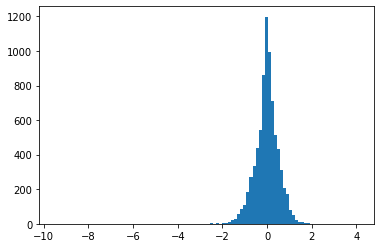

In [115]:
import matplotlib.pyplot as plt
plt.hist(pretrained_hidden[0].reshape(-1).detach().numpy(), bins = 100)